In [2]:
import numpy as np
import mne

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import mne
from mne.io import read_raw_edf
import os
import re
import seaborn as sns
sns.set()

In [4]:
sample_data = read_raw_edf('../data/sleep-cassette/SC4041E0-PSG.edf')
channel_names = sample_data.info['ch_names']
Fs = sample_data.info['sfreq']
eeg_waveform = sample_data.to_data_frame()

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...


In [10]:
print(channel_names)
print(Fs)
eeg_waveform

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
100.0


channel,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,Resp oro-nasal,EMG submental,Temp rectal,Event marker
time,,,,,,,
0,21.255922,3.152625,-27.777778,6.200000e+07,2.982000,3.741038e+07,9.220000e+08
10,12.489621,-8.036630,-48.666667,6.236283e+07,2.982014,3.741050e+07,9.215136e+08
20,7.210989,1.223443,-14.444444,6.272200e+07,2.982005,3.741063e+07,9.210257e+08
30,25.214896,-4.274725,-70.000000,6.307749e+07,2.981971,3.741077e+07,9.205369e+08
40,29.268132,-14.402930,-106.888889,6.342926e+07,2.981914,3.741091e+07,9.200480e+08
...,...,...,...,...,...,...,...
77099950,17.673993,18.489621,7.777778,3.592321e+07,3.136990,3.765867e+07,9.555213e+08
77099960,51.608059,2.380952,26.444444,3.592735e+07,3.137635,3.765882e+07,9.556272e+08
77099970,3.157753,6.142857,12.222222,3.593723e+07,3.138258,3.765896e+07,9.557280e+08


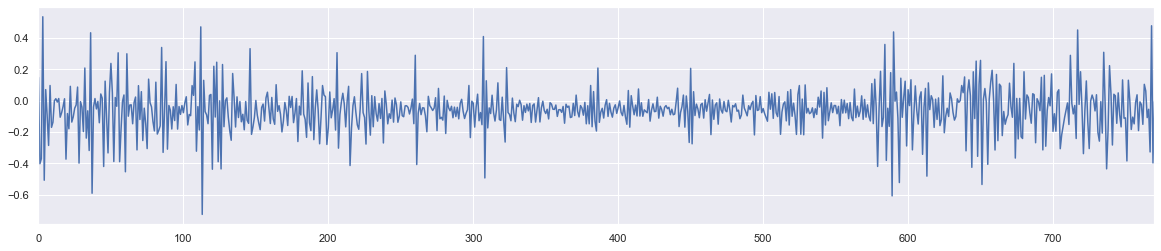

In [26]:
# taking average of every 100 seconds and show first channel time series plot
wave1 = eeg_waveform.iloc[:, 0].values.reshape(-1, 10000)
pd.Series(wave1.mean(axis=1)).plot(figsize=(20,4))

In [34]:
def plot_psg(eeg, save_path=None, thresholds=None):
    eeg_waveform = eeg.to_data_frame()
    channels = eeg_waveform.columns
    plt.figure(figsize=[12, 10])
    for i, channel in enumerate(channels):
        plt.subplot(3, 3, i+1)
        temp = eeg_waveform.iloc[:, i].values
        if thresholds is not None:
            temp = temp[(temp>thresholds[0]) & (temp<thresholds[1])]
            temp = temp[:temp.shape[0]//1000*1000]
        wave = temp.reshape(-1, 1000)
        plt.plot(wave.mean(axis=1), color='k')
        plt.title(channel)
        plt.xlabel('time (10s)')
    plt.tight_layout()
    if isinstance(save_path, str) and len(save_path):
        plt.savefig(save_path)

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7242J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7242J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...


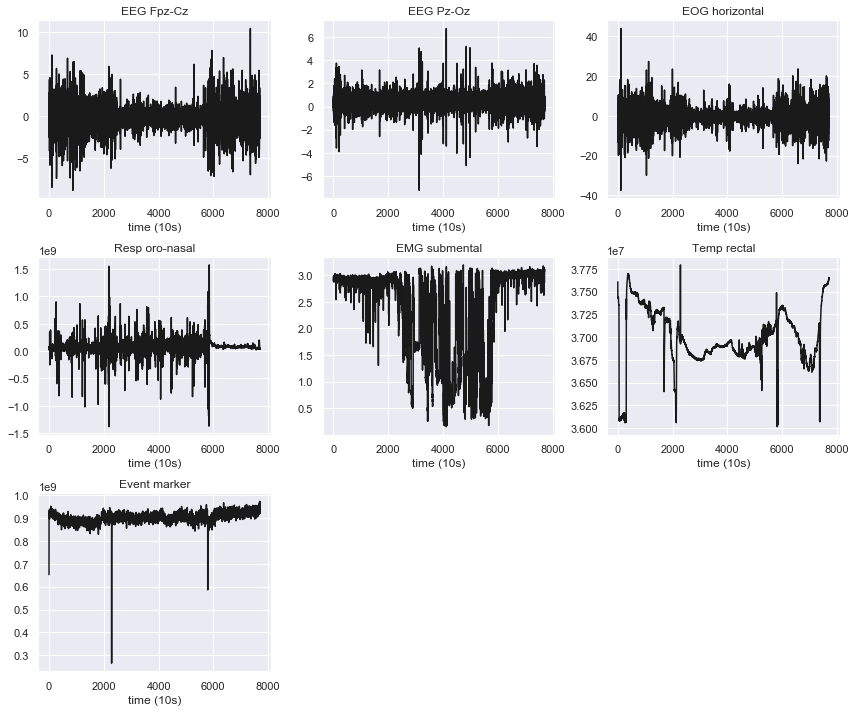

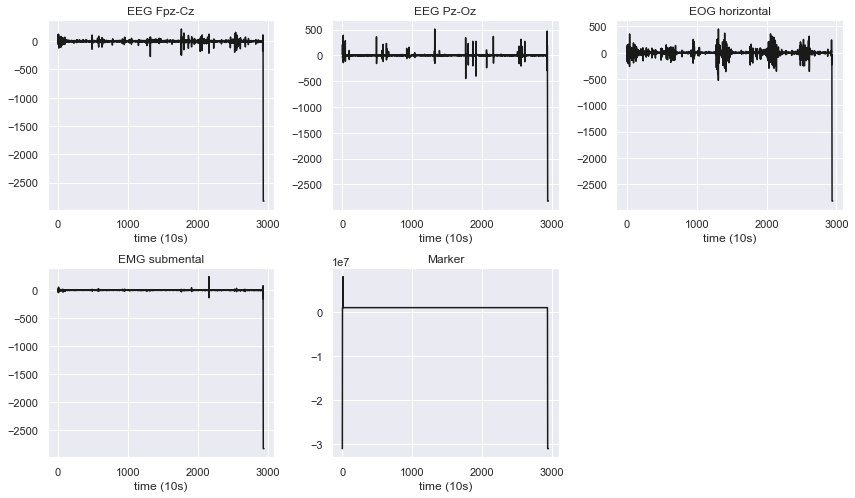

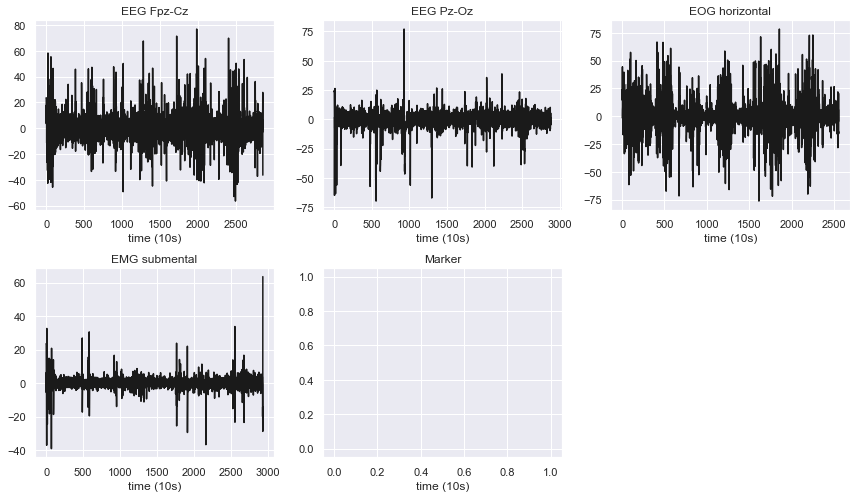

In [36]:
cassete_sample = read_raw_edf('../data/sleep-cassette/SC4041E0-PSG.edf')
plot_psg(cassete_sample)

telemetry_sample = read_raw_edf('../data/sleep-telemetry/ST7242J0-PSG.edf')
plot_psg(telemetry_sample)
# the final drop appears to be outlier

telemetry_sample = read_raw_edf('../data/sleep-telemetry/ST7242J0-PSG.edf')
plot_psg(telemetry_sample, thresholds=[-100, 100])

In [43]:
def read_eeg_info_list(base_path, table_filename='RECORDS'):
    psg_paths = pd.read_table(base_path + '/' + table_filename, header=None).iloc[:, 0].values
    eeg_info_list = []
    for psg_path in psg_paths:
        raw_edf = read_raw_edf(os.path.join(base_path, psg_path))
        edf_df = raw_edf.to_data_frame()
        eeg_info_list.append(
            [psg_path, edf_df.columns.tolist(), edf_df.shape[0]])
    return eeg_info_list

In [46]:
eeg_info_df = pd.DataFrame.from_records(
    read_eeg_info_list('../data', table_filename='RECORDS'),
    columns=['path', 'channels', 'n_records'])
eeg_info_df.to_csv('../data/eeg_info_df.csv', index=False)

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4141E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4142E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4151E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4272F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4281G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4282G0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4422E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4431E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4432E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4562F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4571F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4572F0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4721E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4722E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-cassette/SC4731E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7062J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7071J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7072J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_F

Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7201J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7202J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_Fall/CSE-6250-HealthData/Project/CSE6250-project/data/sleep-telemetry/ST7211J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Extracting EDF parameters from /Users/oulrich/Projects/MastersDegree/Semesters/2019_F

In [47]:
eeg_info_df['n_channels'] = eeg_info_df.channels.map(len)
eeg_info_df['label'] = np.where(eeg_info_df.path.map(
    lambda x: x.split('/')[0]) == 'sleep-telemetry', 1, 0)
eeg_info_df['label'].value_counts()

0    153
1     44
Name: label, dtype: int64

In [48]:
np.unique(eeg_info_df[['label', 'n_channels']].values, axis=0)

array([[0, 7],
       [1, 5]])

In [49]:
channels0 = eeg_info_df.channels.values[0]
channels1 = eeg_info_df.channels.values[-1]
[i for i in channels1 if i in channels0]

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']